# The Trust Region Subproblem

## Introduction
The Trust Region Subproblem (which we will refer to as the TRP) is a Quadratically Constrained Quadratic Program (QCQP) with a single norm constriant. This is a problem of the form 

\begin{align*}
\min_{y \in \mathbb{\delta}^n} \quad & \frac{1}{2} y^T Q y + g^T y \\
\text{s.t} \quad & \|y\| \leq \delta
\end{align*}

where $Q$ is a Positive semi-definite matrix in $\mathbb{\delta}^{n \times n}$, and $g \in \mathbb{\delta}^n$. While I will not go in depth into the applications of solving the TRP, know that it is widely used. Solving the TRP is especially important in non-linear optimization with Interior Point Methods, optimization on reimannian manifolds, motion planning with contacts, etcetera. Methods to approximately solve the TRP exist (for instance, dog-leg methods and methods based on the Cauchy point). We will focus instead on methods to solve it exactly. 

We will not explicitly consider QCQPs with ellipsoidal constraints, such as 

\begin{align*}
\min_{y \in \mathbb{\delta}^n} \quad & \frac{1}{2} y^T Q y + g^T y \\
\text{s.t} \quad & \|Cy + c\| \leq \delta
\end{align*}

As noted in More and Sorensons seminal work on [Computing A Trust Region Step](https://digital.library.unt.edu/ark:/67531/metadc283525/m2/1/high_res_d/metadc283525.pdf), the two problems are equivalent under change of variables (assuming $C$ is full rank).


We can create an example TRP problem with the following.

In [1]:
import numpy as np
from maptrp import QuadraticCostStruct, SolverInput

N = 1000 # Example dimension, can be adjusted as needed
delta = 1.0 # radius of the feasible set. This set is a ball centered at the origin.

seed = 0
np.random.seed(seed)

unconstrained_solution_norm = 0.0
while True:
    Q_sqrt = np.random.rand(N, N)
    Q = Q_sqrt @ Q_sqrt.T  # Ensure Q is positive definite
    g = np.random.rand(N)

    #ensure that the unconstrained solution is outside the feasible set.
    unconstrained_solution = np.linalg.solve(Q, g)
    unconstrained_solution_norm = np.linalg.norm(unconstrained_solution)
    if unconstrained_solution_norm >= delta:
        break
    else:
        seed += 1
        np.random.seed(seed)

cost_struct = QuadraticCostStruct(Q=Q, g=g)
print(f"Using seed {seed} for the random number generator.")

print(f"The quadratic cost function is minimized {unconstrained_solution_norm:.2f} units away from the origin, which is outside the feasible set of radius {delta:.2f}.")

Using seed 0 for the random number generator.
The quadratic cost function is minimized 2695.89 units away from the origin, which is outside the feasible set of radius 1.00.


## Solving the TRP 


### Optimality from the Tikhanov Regularized Least Squares

Let us consider the KKT conditions of the TRP. For now, we restrict our analysis to problems where the solution is on the boundary of the feasible set. In this case, $\|y\|^2 = \delta$, and the complimentary slackness condition can be ignored. Thus, the KKT conditions are 
\begin{align*}
\nabla_y f(y) + \lambda y = (Qy + g) + y\lambda = 0 \\
\lambda \geq 0 \\
\|y\|^2 - \delta^2 = 0 
\end{align*}


Where $f(y)$ is the quadratic cost, and $\nabla_y f(y)$ is the gradient of the cost. Through algebraic maniputaion of the above conditions, we recover the following conditions for some pair of primal and dual variables ($y, \lambda$) to be valid
$$y = -(Q+\lambda)^{-1}g \quad s.t \quad \|y\|^2 = \delta$$

At the optimal dual variable ($\lambda^*$), thus, 

\begin{equation}
\|(Q+\lambda^*)^{-1}g\|^2 = \delta^2
\end{equation}

We recover $y$ from this dual variable as $y^* = -(Q+\lambda^*)^{-1}g$. 

This is known as the Tikhanov Regularized Least Squares solution, and is also the solution to the problem 
\begin{align*}
\min_{y \in \mathbb{\delta}^n} \quad & \frac{1}{2} y^T Q y + g^T y + \lambda\|y\|^2
\end{align*}
where $\lambda$ is a regularization term. 

Note (from (1)) that $y = -(Q+\lambda)^{-1}g$ is always an optimal solution to the problem 
\begin{align*}
    \min_{y \in \mathbb{\delta}^{n}} \quad & \frac{1}{2} y^T Q y + g^T y \\
    \text{s.t} \quad & \|y\| = \|(Q+\lambda)^{-1}g\|
\end{align*}


Established methods only need to search for appropriate $\lambda \geq 0$, such that $\|(Q+\lambda)^{-1}g\| = \delta$. 


## Newtons Method to search for optimal $\lambda$.

The approach proposed by [More and Sorenson](), and reiterated in [Numerical Optimaztion](), utilizes Newton's method to converge to the optimal $\lambda$ s.t. $\|(Q+\lambda)^{-1}g\| - \delta = 0$. 

We can define a function, $$\phi_1(\lambda) = \|(Q+\lambda)^{-1}g\|^2 - \delta^2$$ which has a root at the desired optimal $\lambda$. $\phi_1(\lambda)$ is a non-linear function of $\lambda$, and using Newtons method to find the desired root results in undesirable behavior. 

Thus, More and Sorenson attempt to find roots of $$\phi(\lambda) = \frac{1}{\|(Q+\lambda)^{-1}g\|} - \frac{1}{\delta} = 0$$ instead. $\frac{1}{\|(Q+\lambda)^{-1}g\|}$ is approximately linear about the eigenvalues of $\lambda$. For a  more detailed explanation, see [Numerical Optimaztion]().

The rule for updating a guess for $\lambda$ based on the newton step is given by $$\lambda^+ = \lambda^- - \frac{\phi(\lambda^-)}{\phi'(\lambda^-)}$$ which can be simplified to $$\lambda^+ = \lambda^- + \left(\frac{\|y\| - \delta}{\delta}\right) \left(\frac{y(\lambda)^T y(\lambda)}{y(\lambda)^T (Q + \lambda)^{-1} y(\lambda)}\right)$$, often represented as $$\lambda^- + \left(\frac{\|p\| - \delta}{\delta}\right) \left(\frac{\|p\|}{ \|q\|}\right)^2$$ where $p = y(\lambda) = -(Q+\lambda)^{-1}g$, $q = R^{-T}p$, and $R^TR = (Q + \lambda)$ is the cholesky decomposition of the regularized cost.


Let us implement this method below.


In [2]:
from maptrp import TRP_solver_base
# We extend the base class and implement a new stepping strategy using Newton's method.
class newton_TRP_solver(TRP_solver_base):
    """Newton's method solver for the TRP problem."""
    def step_basic(self):
        lambda_minus = self.lambda_

        Q_regularized = self.Q() + self.lambda_ * np.eye(self.Q().shape[0])
        Q_reg_inv = np.linalg.inv(Q_regularized)

        y = -Q_reg_inv @ self.g()

        y_norm = np.linalg.norm(y)
        delta = self.radius()  # desired radius

        y_percent_diff = (y_norm - delta) / delta
        right_term = ((y.T @ y) / (y.T @ Q_reg_inv @ y))
        step = y_percent_diff * right_term

        self.lambda_ += step

        # Let us calculate the exact difference between the current solution norm and the desired radius. 
        # We use this to determine the termination condition.
        y = self.recover_incremental_solution()
        y_norm = np.linalg.norm(y)
        y_diff = abs(y_norm - delta)
        return y_diff
    
    def step_w_eigendecomp(self):
        """Step using precomputed eigendecomposition."""

        #This relies on the eigen decomposition of the cost matrix Q, which can be precomputed to enhance iteration times.
        # If Q=V * diag(eig) * V^T, then we can compute the inverse of (Q + lambda I) as
        # (V * diag(eig + lambda) * V^T)^-1 = V * diag((eig + lambda)^-1) * V^T

        lambda_minus = self.lambda_

        eig_plus_lambda_inv = (self.precomputed_data.eig + lambda_minus) ** -1
        eig_plus_lambda_inv_sq = eig_plus_lambda_inv ** 2
        # ||y(lambda)||^2 on the other hand, is computed as
        # ||y(lambda)||^2 = (V^T g)^T * ((diag(eig) + lambda)^-2) * (V^T g) = <(eig + lambda)^{-2}, (V^T g)^2>
        y_norm_sq = np.dot(self.precomputed_data.v_tsps_g_sq, eig_plus_lambda_inv_sq)

        eig_plus_lambda_inv_cubed = eig_plus_lambda_inv ** 3
        # ||R^{-T}y|| = y^T (Q+lambda I)^{-1} y = <(eig + lambda)^{-3}, (V^T g)^2>
        q_norm_sq = np.dot(self.precomputed_data.v_tsps_g_sq, eig_plus_lambda_inv_cubed)

        y_percent_diff = (np.sqrt(y_norm_sq)/ self.radius() - 1.0)
        right_term = (y_norm_sq / q_norm_sq)
        step = y_percent_diff * right_term
        self.lambda_ += step

        
        # Calculating the difference between the current solution norm and the desired radius is expensive. 
        # Let us instead evaluate termination by change in lambda.
        return abs(self.lambda_ - lambda_minus)



In [3]:
solver_input = SolverInput(
    cost_struct=cost_struct,
    radius=delta,
    tolerance=1e-3, # convergence criterion. We have defined this as the difference between the solution norm and the desired radius.
    use_eigendecomp=True
)


solver = newton_TRP_solver(solver_input)
solver.set_lambda(30)
solution, iterations, experiment_result_data, total_time = solver.solve_with_experiment_result_data()
print("r - delta: ", np.linalg.norm(solution) - delta) # what is the difference between the solution norm and the desired radius? 
print("Iterations:", iterations)
print("Solution lambda: ", solver.lambda_)

r - delta:  2.220446049250313e-16
Iterations: 6
Solution lambda:  2.91697999062052


### Non-optimality

Note that, while the optimal $\lambda^* \geq 0$ such that $\|(Q+\lambda)^{-1} g\|^2 = \delta^2$ is a root of $\phi(\lambda)$, it is not necessarily the only one. Let us look at the roots of the given system.

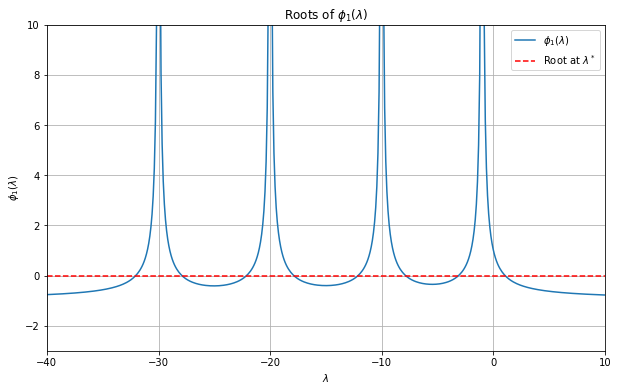

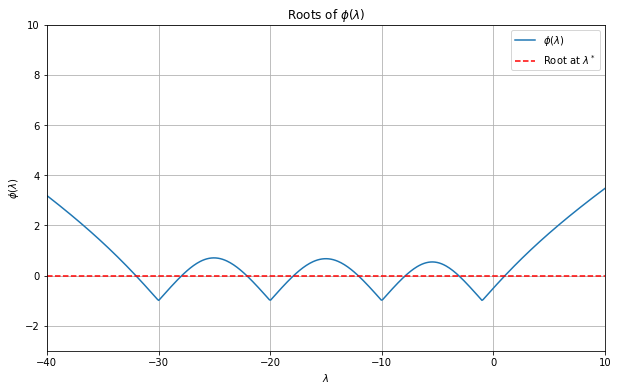

In [4]:
import matplotlib.pyplot as plt
import numpy as np
Q = np.diag([1, 10, 20, 30])
g = 0.2*np.array([10, 10, 10, 10])
delta = 1.0

y_lambda = lambda lambda_: -np.linalg.solve(Q + (lambda_ * np.eye(4)), -g)

phi_1 = np.array([ np.linalg.norm(y_lambda(lambda_)) - delta for lambda_ in np.linspace(-40, 10, 500)])
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(-40, 10, 500), phi_1, label=r"$\phi_1(\lambda)$")
plt.axhline(0, color='red', linestyle='--', label='Root at $\lambda^*$')
plt.title(r"Roots of $\phi_1(\lambda)$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\phi_1(\lambda)$")
plt.legend()
plt.grid()
plt.xlim(-40, 10)
plt.ylim(-3, 10)
plt.show()

phi = np.array([1.0 / np.linalg.norm(y_lambda(lambda_)) - 1.0 / delta for lambda_ in np.linspace(-40, 10, 500)])
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(-40, 10, 500), phi, label=r"$\phi(\lambda)$")
plt.axhline(0, color='red', linestyle='--', label='Root at $\lambda^*$')
plt.title(r"Roots of $\phi(\lambda)$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\phi(\lambda)$")
plt.legend()
plt.grid()
plt.xlim(-40, 10)
plt.ylim(-3, 10)
plt.show()

There are at least 8 roots in the above system. Root-finding methods may converge to an inaccurate solution, where $\lambda < 0$.
Thus, the convergence of the above methods are dependant on the initial guess for $\lambda$ being near the optimal guess.

It is noted that the above method is not able to find accurate values for gradients when $Q$ is ill-conditioned. This is because (at a near-singular value) the computation of $q$ becomes hard.

See the below example, which converges to an inaccurate solution with a reasonable initial guess of $\lambda = 70$.

In [5]:
import numpy as np
from maptrp import QuadraticCostStruct, SolverInput


solver = newton_TRP_solver(solver_input)
solver.set_lambda(70)  # Set an initial guess for lambda such that y(lambda) is approx 0.
solution, iterations, experiment_result_data, total_time = solver.solve_with_experiment_result_data()
print("Iterations:", iterations)
print("Solution lambda: ", solver.lambda_)


Iterations: 24
Solution lambda:  -167.06483984070766


## New method with convergence guarantees.

We propose a new method that guarantees convergence to the correct root of the system, even when the cost matrix is ill-conditioned.

### The Optimal Curve
Let us define $Y \subset \mathbb{\delta}^{N_y}$, the set of optimal solutions to the TRP with arbitrary desired radius. This is the set
\begin{align*}
Y = \{y \quad | \quad \exists \delta \quad s.t. \quad y= 
    \begin{smallmatrix}
    \min_{y \in \mathbb{\delta}^{N_y}} \quad & \frac{1}{2} y^T Q y + g^T y \\
    \text{s.t} \quad & \|y\| \leq \delta
    \end{smallmatrix}
\}
\end{align*}


Every value $y* \in Y$ is the optimal solution to the TRP where $\delta = \|y^*\|$. This is a 1-dimensional manifold in the space of $\mathbb{\delta}^{N_y}$, hence, we will call it the optimal curve. In other literature, this may even be refered to as the optimal trajectory. The objective of the TRP solver can be viewed as finding the point where this curve intersects the desired $\delta$-ball.


#### Intuition Behind The Optimal Curve
$y \in Y$, by definition, is a value that respects the stationarity conditions of the TRP. When the unconstrained minimum is not in the ball ($ ||-Q^{-1} g|| > r$), the stationarity conditions enforce that the gradient of $f$ at the optimal point is in the opposite direction of the gradient of $||y||^2$, or that $$\nabla_y f(y^*) = - \lambda y^*$$ where $\lambda \geq 0 $. These gradients are the surface normals of the respective ellipsoids (the normals of the level set of $f$ containing $y^*$ and the ball $||y||^2 \leq r$). This indicates that the surface of these ellipsoids are tangent, and intersect only at $y^*$. Each point on this curve has an associated $\lambda(y)$ such that $y = Y^*(\lambda(y))$. From the above property, $\lambda(y \in Y)$ is given by $$\lambda(y) = \frac{||\nabla_yf(y)||}{||y||}$$. When the unconstrained optimum ($-Q^{-1} g$) is inside the ball, $\lambda(-Q^{-1} g) = \frac{||\nabla_yf(-Q^{-1} g)||}{||-Q^{-1} g||}$ still holds, with $\lambda = ||\nabla_yf(-Q^{-1} g)|| = 0$. Alternatively, as $\lambda$ approaches $\infty$, the associated optimal solution $Y^*(\lambda)$ approaches $0$. 

The optimal curve is not only parameterized by $\lambda$, but can also be parameterized by the radius, $r = \|y\|$. We can recover the radius associated with the regularization term $\lambda$ as $r = \|Y^*(\lambda)\| = \|-(Q + \lambda I)^{-1}g\|$. This indicates an inversely proportional relationship between $\lambda$ and $r(\lambda) = \|Y^*(\lambda)\|$, or that $\frac{d}{d\lambda} \|Y^*(\lambda)\| \leq 0$. This makes intuitive sense. Note that $r = \|y\|$ is monotonically increasing on the curve (going from $0$ to some $r_{max} = \|-Q^{-1} g\|$), as one follows the curve from $y=0$ to the unconstrained solution, values which mark the boundary of $Y$. Alternatively, $\lambda(y)$ is monotonically decreasing in the same direction (from $\lambda(0) = \infty$ to $\lambda(-Q^{-1} g) = 0$), indicating a strict inverse relationship between $r$ and $\lambda$. 


For brevity, we will not prove this "Bias-Variance tradeoff" here (proof can be found on the shared overleaf document). Important for later, we can also show that there is additionally a strictly increasing relationship between $\lambda$ and $\|\nabla_y f(Y^*(\lambda))\|$.


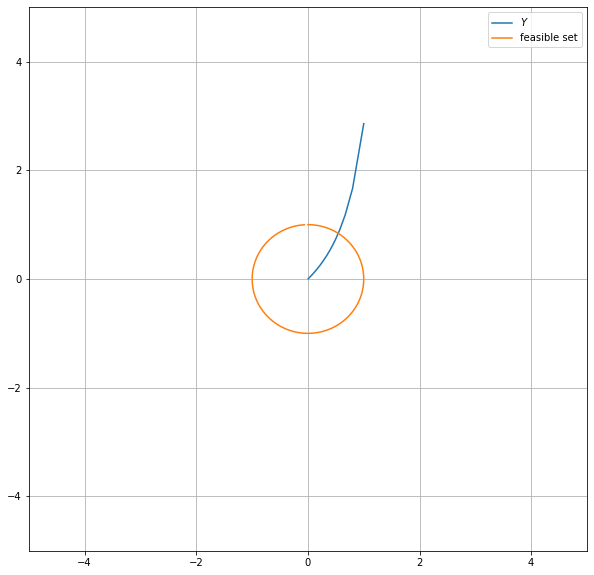

In [6]:
import matplotlib.pyplot as plt
import numpy as np
Q = np.diag([4, 1.4, 5, 1])
g = -4*np.array([1, 1, 1, 1])
delta = 1.0

y_curve = [ np.linalg.solve(Q + lambda_ * np.eye(4), -g) for lambda_ in range(0, 1000, 1) ]
plt.figure(figsize=(10, 10))
plt.plot([y_curve[i][0] for i in range(1000)], [y_curve[i][1] for i in range(1000)], label=r"$Y$")
plt.plot([delta * np.sin(2*np.pi*theta/100) for theta in range(100)], [delta * np.cos(2*np.pi*theta/100) for theta in range(100)], label=r"feasible set")

plt.legend()
plt.grid()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Optimization using a new attractor function 

Let us consider the discrete time system, 
\begin{align}
    \lambda^+ = \frac{||\nabla_y f(y^{-})||}{\delta} \\
    y^+ = -(Q + \lambda^+)^{-1} g = Y^*(\lambda^+)
\end{align}
where $y^+$ is the value of the system at the next time-step and $\delta$ is the desired solution norm. Alternatively, we can consider  
\begin{align}
    \lambda^+ = \frac{||\nabla_y f( Y^*(\lambda^-) )||}{\delta}
\end{align}


Equilibrium is reached when $y^+ = Y^*(\frac{\|\nabla_y f(y^-) \|}{\delta}) = y^-$. In the case that $\|y^-\| = \delta$, $$Y^*\left(\frac{\|\nabla_y f(y^-) \|}{\delta}\right) = Y^*\left(\frac{\|\nabla_y f(y^-) \|}{\|y^-\|}\right) = Y^*\left(\lambda(y^-)\right)$$

From the definition of our optimal map, $Y^*(\lambda(y^-)) = y^-$ holds if $y \in Y$. 

Thus, any $y \in Y$ such that $\|y\| = \delta$ is an equilibrium to the above system. These are also the conditions of optimality (stationarity and primal feasibility, respectively) to the given optimization problem, indicating that this equilibrium point is an optimal solution.


While we leave the proof out of this document for brevity, we can also show that the above system does indeed converge to this equilibrium point, with $$\lambda^- > \lambda^+ > \lambda^{opt}$$ or $$\lambda^{opt} > \lambda^+ > \lambda^-$$, depending on the initial guess for $y$. Our updated value for $y$, essentially, is guaranteed to be bounded by the previous value and the optimal value.

Our new iteration rule is simply 
$$ \lambda^+ = \frac{\|f(Y^*(\lambda^-)\|}{\delta} = \lambda^- \frac{\|Y^*(\lambda^-)\|}{\delta}$$

In [7]:
from maptrp import TRP_solver_base
# We extend the base class and implement a new stepping strategy using Newton's method.
class new_TRP_solver(TRP_solver_base):
    """Implement the new method for solving the TRP problem."""
    def step_basic(self):
        lambda_minus = self.lambda_

        y = self.recover_incremental_solution()
        y_norm = np.linalg.norm(y)

        self.lambda_ = lambda_minus * y_norm / self.radius()  # Update lambda based on the gradient norm and radius

        # Let us calculate the exact difference between the current solution norm and the desired radius. 
        # We use this to determine the termination condition.
        y = self.recover_incremental_solution()
        y_norm = np.linalg.norm(y)
        y_diff = abs(y_norm - self.radius())
        return y_diff
    
    def step_w_eigendecomp(self):
        """Step using precomputed eigendecomposition."""

        #This relies on the eigen decomposition of the cost matrix Q.
        # If Q=V * diag(eig) * V^T, then we can compute the inverse of (Q + lambda I) as
        # (V * diag(eig + lambda) * V^T)^-1 = V * diag((eig + lambda)^-1) * V^T

        lambda_minus = self.lambda_

        y_norm_over_d_sq = np.dot(self.precomputed_data.vg_over_dsq, (self.precomputed_data.eig + lambda_minus) ** -2)
        self.lambda_ = lambda_minus * np.sqrt(y_norm_over_d_sq) 

        # Calculating the difference between the current solution norm and the desired radius is expensive. 
        # Let us instead evaluate termination by change in lambda.
        return abs(self.lambda_ - lambda_minus)


In [ ]:
solver_input = SolverInput(
    cost_struct=cost_struct,
    radius=delta,
    tolerance=1e-3, # convergence criterion.
    use_eigendecomp=True
)


solver = new_TRP_solver(solver_input)
solver.set_lambda(70)
solution, iterations, experiment_result_data, total_time = solver.solve_with_experiment_result_data()
print("r - delta: ", np.linalg.norm(solution) - delta) # what is the difference between the solution norm and the desired radius? 
print("Iterations:", iterations)
print("Solution lambda: ", solver.lambda_)

r - delta:  -4.619148357121183e-05
Iterations: 7
Solution lambda:  2.9171508339330954


## Robustness to initial guess


In [9]:
print("with old solver:")
for i in range(10):
    solver = newton_TRP_solver(solver_input)
    init_lambda = pow(10, i - 4)  # Initial guess for lambda
    solver.set_lambda(init_lambda)  # Set a range of lambda values to test convergence
    solution, iterations = solver.solve()
    lambda_sol = solver.lambda_
    print(f"guess: {init_lambda}, solution lambda: {lambda_sol:.2f}, iterations: {iterations}")
print("with new solver:")
for i in range(10):
    solver = new_TRP_solver(solver_input)
    init_lambda = pow(10, i - 4)  # Initial guess for lambda
    solver.set_lambda(init_lambda)  # Set a range of lambda values to test convergence
    solution, iterations = solver.solve()
    lambda_sol = solver.lambda_
    print(f"guess: {init_lambda}, solution lambda: {lambda_sol:.2f}, iterations: {iterations}")


with old solver:
guess: 0.0001, solution lambda: 2.92, iterations: 5
guess: 0.001, solution lambda: 2.92, iterations: 5
guess: 0.01, solution lambda: 2.92, iterations: 5
guess: 0.1, solution lambda: 2.92, iterations: 4
guess: 1, solution lambda: 2.92, iterations: 4
guess: 10, solution lambda: 2.92, iterations: 4
guess: 100, solution lambda: -260.61, iterations: 77
guess: 1000, solution lambda: -299.34, iterations: 600
guess: 10000, solution lambda: -106.70, iterations: 53
guess: 100000, solution lambda: 2.92, iterations: 571
with new solver:
guess: 0.0001, solution lambda: 2.92, iterations: 8
guess: 0.001, solution lambda: 2.92, iterations: 8
guess: 0.01, solution lambda: 2.92, iterations: 8
guess: 0.1, solution lambda: 2.92, iterations: 7
guess: 1, solution lambda: 2.92, iterations: 7
guess: 10, solution lambda: 2.92, iterations: 7
guess: 100, solution lambda: 2.92, iterations: 7
guess: 1000, solution lambda: 2.92, iterations: 8
guess: 10000, solution lambda: 2.92, iterations: 8
guess

## Tests

In [14]:
def CompareSols(solver_input, initial_guess_lambda=None):
    """Compare the solutions of the Newton's method and the new method for the TRP problem."""


    # unconstrained_solution = np.linalg.solve(solver_input.cost_struct.Q, solver_input.cost_struct.g)
    # initial_guess = solver_input.radius * unconstrained_solution / unconstrained_solution_norm  # Initial guess is a point on the boundary of the feasible set

    #Implement with Newton's method
    solver = newton_TRP_solver(solver_input)
    if initial_guess_lambda is not None:
        solver.set_lambda(initial_guess_lambda)
    else:
        solver.set_default_initial_guess()  # Set the initial guess based on the unconstrained solution 
    solution, iterations, newton_exp_data, total_time = solver.solve_with_experiment_result_data(20)
    print("Newtons method primal violation: ", np.linalg.norm(solution) - solver_input.radius) # what is the difference between the solution norm and the desired radius? 
    print("Newtons Method Iterations:", iterations)
    print("Total time taken for iterations: ", total_time)


    #Implement with the new method
    solver = new_TRP_solver(solver_input)
    if initial_guess_lambda is not None:
        solver.set_lambda(initial_guess_lambda)
    else:
        solver.set_default_initial_guess()  # Set the initial guess based on the unconstrained solution
    solution, iterations, new_exp_data, total_time = solver.solve_with_experiment_result_data(20)
    print("New method primal violation: ", np.linalg.norm(solution) - solver_input.radius) # what is the difference between the solution norm and the desired radius? 
    print("New method Iterations:", iterations)
    print("Total time taken for iterations: ", total_time)

    return new_exp_data, newton_exp_data

def plot_result_data(new_exp_data, newton_exp_data):
    """Plot the results of the experiment."""
    import matplotlib.pyplot as plt
    new_convergence_metric = [data["convergence_metric"] for data in new_exp_data.values()]
    new_lambda_values = [data["lambda"] for data in new_exp_data.values()]
    new_radii = [data["radius"] for data in new_exp_data.values()]
    new_cost = [data["cost"] for data in new_exp_data.values()]

    # Extract the steplengths from the newton_experiment_result_data
    newton_convergence_metric = [data["convergence_metric"] for data in newton_exp_data.values()]
    newton_lambda_values = [data["lambda"] for data in newton_exp_data.values()]
    newton_radii = [data["radius"] for data in newton_exp_data.values()]
    newton_cost = [data["cost"] for data in newton_exp_data.values()]


    # Plotting the results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    # plt.subplot(1, 4, 1)
    # plt.plot(new_convergence_metric, label='New Method Convergence Metric', marker='o')
    # plt.plot(newton_convergence_metric, label='Newton Method Convergence Metric', marker='x')
    # plt.xlabel('Iteration')
    # plt.ylabel('Convergence Metric')
    # plt.legend()
    # plt.title('Convergence Metric Comparison')

    plt.subplot(1, 3, 1)
    plt.plot(new_lambda_values, label='New Method Lambda Values', marker='o')
    plt.plot(newton_lambda_values, label='Newton Method Lambda Values', marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Lambda Value')
    plt.legend()
    plt.title('Lambda Values Comparison')

    plt.subplot(1, 3, 2)
    plt.plot(new_radii, label='New Method Radii', marker='o')
    plt.plot(newton_radii, label='Newton Method Radii', marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Radius')
    plt.legend()
    plt.title('Radii Comparison')

    plt.subplot(1, 3, 3)
    plt.plot(new_cost, label='New Method Cost', marker='o')
    plt.plot(newton_cost, label='Newton Method Cost', marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.title('Cost Comparison')

    plt.tight_layout()
    plt.show()


## Test with a well conditioned cost. 
This cost has uniform eigenvalues. Finding the optimal solution should be equivalent to projecting the unconstrained optimal solution onto the feasible set.

Newtons method primal violation:  -2.220446049250313e-16
Newtons Method Iterations: 2
Total time taken for iterations:  0.0001461505889892578
New method primal violation:  -0.00015022342027426472
New method Iterations: 5
Total time taken for iterations:  9.632110595703125e-05


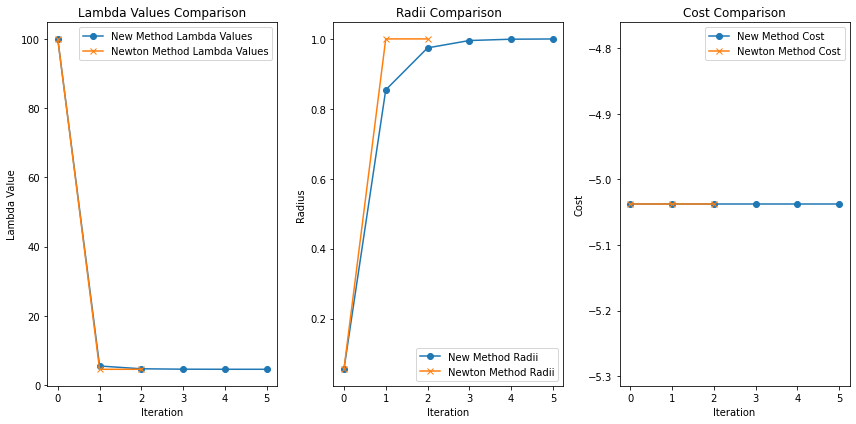

In [16]:
import numpy as np
from maptrp import QuadraticCostStruct, SolverInput

N = 100 # Example dimension, can be adjusted as needed

delta = 1.00 # radius of the feasible set. This set is a ball centered at the origin.

seed = 0
np.random.seed(seed)

while True:
    
    Q = np.identity(N) 
    g = np.random.rand(N)
    
    unconstrained_solution = np.linalg.solve(Q, g)
    unconstrained_solution_norm = np.linalg.norm(unconstrained_solution)
    if unconstrained_solution_norm >= delta:
        break
    else:
        seed += 1
        np.random.seed(seed)

cost_struct = QuadraticCostStruct(Q=Q, g=g)


solver_input = SolverInput(
    cost_struct=cost_struct,
    radius=delta,
    tolerance=1e-2, # convergence criterion.
    use_eigendecomp=True, 
)

# provide an initial guess of 100.
new_exp_data, newton_exp_data = CompareSols(solver_input, 100)

plot_result_data(new_exp_data, newton_exp_data)

Note that, for a cost matrix with uniform eigenvalues, the solution is equivalent to projecting the unconstrained solution ($-Q^{-1}g$) onto the feasible set. The established method for solving the Trust region problem undoubtedly does better in this scenario. 

At each iteration we note the value for $\lambda$, the radius of the recovered solution ($\|Y(\lambda)\| = \|(Q + \lambda)^{-1}g\|$), and the cost of the solution we would get if we terminated the program and projected $Y(\lambda)$ onto the surface of the feasible set. This cost value is $f(\frac{Y(\lambda)}{\|Y(\lambda)\|})$, and not $f(Y(\lambda))$. We can see that, for this well conditioned case, the optimal cost is exactly the same for either method at each iteration, as the optimal curve linearly interpolates between $Y^*(0) = -Q^{-1}g$ and $Y^*(\infty) = 0$.

## Test with a large singular matrix

Newtons method primal violation:  -1.1102230246251565e-16
Newtons Method Iterations: 5
Total time taken for iterations:  0.0004100799560546875
New method primal violation:  -2.1681996383859925e-06
New method Iterations: 6
Total time taken for iterations:  0.00038170814514160156


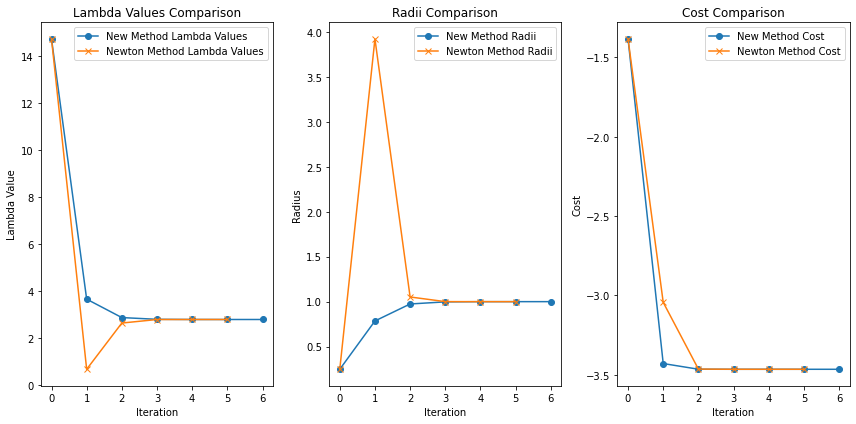

In [26]:
import numpy as np
from maptrp import QuadraticCostStruct, SolverInput

N = 700 # Example dimension, can be adjusted as needed

delta = 1.0 # radius of the feasible set. This set is a ball centered at the origin.

seed = 1
np.random.seed(seed)


while True:
    Q_sqrt = np.random.rand(N, N)
    Q = Q_sqrt @ Q_sqrt.T  # Ensure Q is positive definite
    g = np.random.rand(N) * 1

    Q_eig, Q_eigvec = np.linalg.eigh(Q)
    # make the last few eigenvalues 0
    Q_eig[:100] =  0 

    Q = Q_eigvec @ np.diag(Q_eig) @ Q_eigvec.T  # Reconstruct the matrix with modified eigenvalues
    unconstrained_solution = np.linalg.solve(Q, g)
    unconstrained_solution_norm = np.linalg.norm(unconstrained_solution)
    if unconstrained_solution_norm >= delta:
        break
    else:
        seed += 1
        np.random.seed(seed)

cost_struct = QuadraticCostStruct(Q=Q, g=g)


solver_input = SolverInput(
    cost_struct=cost_struct,
    radius=delta,
    tolerance=1e-4, # convergence criterion.
    use_eigendecomp=True, 
)

# The default initial guess ||nabla f(delta * unconstrained_solution.normalize())|| / delta
# This would be the optimal value of lambda if Q had uniform eigenvalues.
new_exp_data, newton_exp_data = CompareSols(solver_input)
plot_result_data(new_exp_data, newton_exp_data)




We create a somewhat large (700 x 700) cost matrix, purposefully set it to be singular, and attempt to solve the trp with this random matrix.

This is a more interesting experiment. In order to be stable, Newtons method must iterate in such a way that $\lambda$ is always greater than $-\Lambda_0$, where $\Lambda_0$ is the smallest eigenvalue of $Q$. This is achieved in this case, but it can be seen that the value for $\lambda$ overshoots the optimal in the first step. While not obvious, the cost recovered from lambda in the first few iterations from newtons method is larger than our new method. 

Notice that the new method converges to an approximately accurate solution faster than newtons method, but takes more iterations to reach a more exact solution.

## Randomized PSD matrices


condition number:  37042796254.02057
Iteration limit reached: 20. Stopping the solver.
Newtons method primal violation:  19.278288247268748
Newtons Method Iterations: 20
Total time taken for iterations:  0.002034425735473633
New method primal violation:  -3.662431780071529e-08
New method Iterations: 13
Total time taken for iterations:  0.0007276535034179688


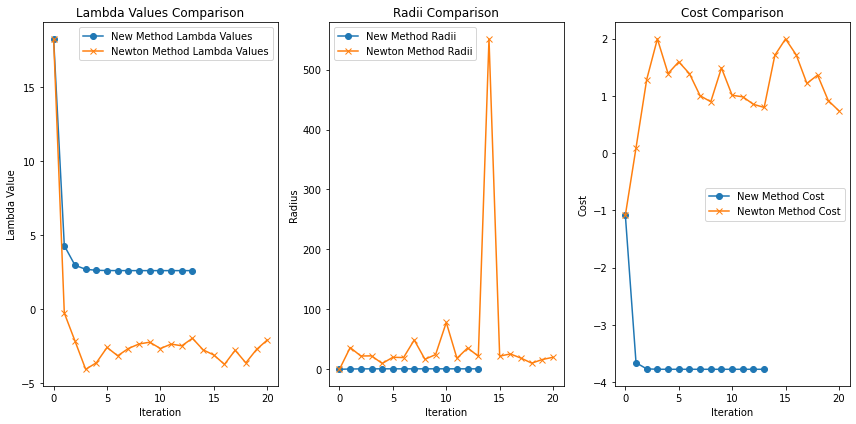

condition number:  12450506487173.514
Newtons method primal violation:  -2.220446049250313e-16
Newtons Method Iterations: 7
Total time taken for iterations:  0.0006661415100097656
New method primal violation:  -6.399943219825843e-08
New method Iterations: 12
Total time taken for iterations:  0.0007863044738769531


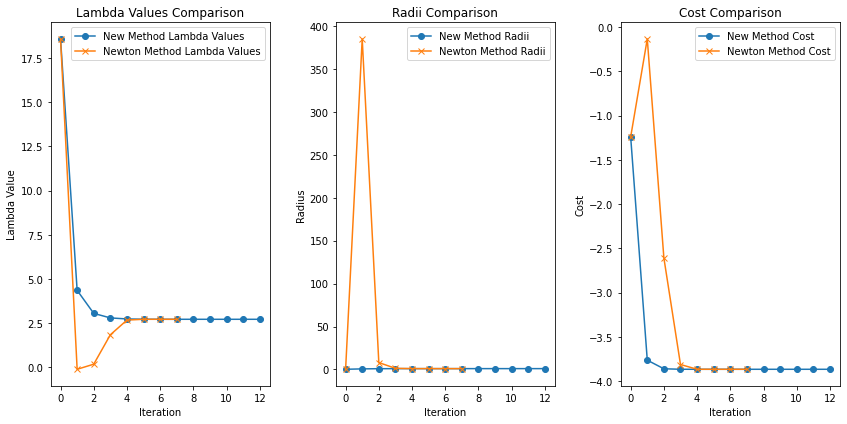

condition number:  118699427395.69945
Iteration limit reached: 20. Stopping the solver.
Newtons method primal violation:  322.7184002622409
Newtons Method Iterations: 20
Total time taken for iterations:  0.0025289058685302734
New method primal violation:  -2.280566058221467e-08
New method Iterations: 12
Total time taken for iterations:  0.0008220672607421875


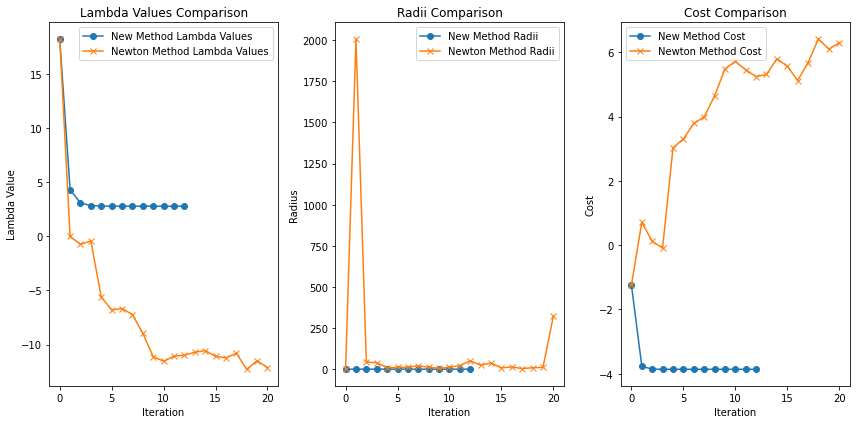

condition number:  1484860168101.1553
Iteration limit reached: 20. Stopping the solver.
Newtons method primal violation:  93.07555347077839
Newtons Method Iterations: 20
Total time taken for iterations:  0.0023021697998046875
New method primal violation:  -6.862079704461621e-08
New method Iterations: 12
Total time taken for iterations:  0.0007658004760742188


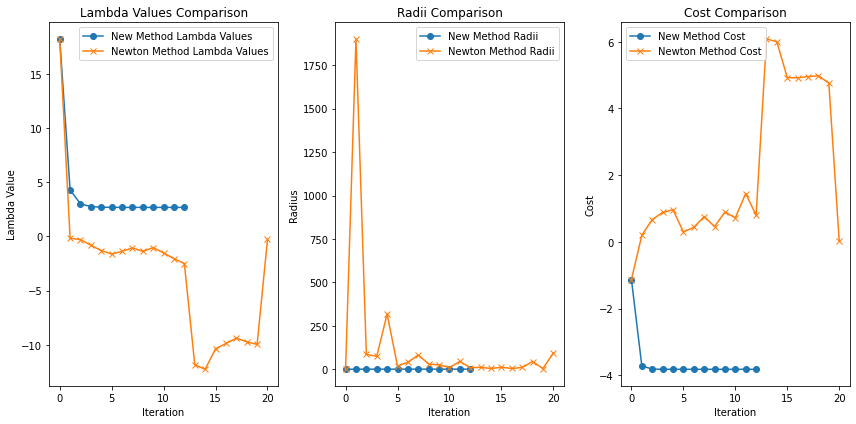

condition number:  2133101001.185163
Newtons method primal violation:  2.220446049250313e-15
Newtons Method Iterations: 5
Total time taken for iterations:  0.0006554126739501953
New method primal violation:  -4.602580350177021e-08
New method Iterations: 12
Total time taken for iterations:  0.000972747802734375


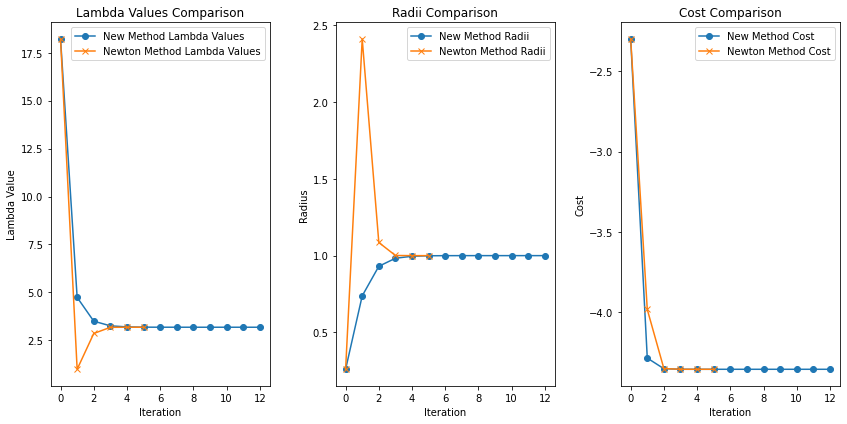

condition number:  29236593725.380283
Newtons method primal violation:  0.0
Newtons Method Iterations: 8
Total time taken for iterations:  0.0007269382476806641
New method primal violation:  -2.3611801180933867e-08
New method Iterations: 13
Total time taken for iterations:  0.0009779930114746094


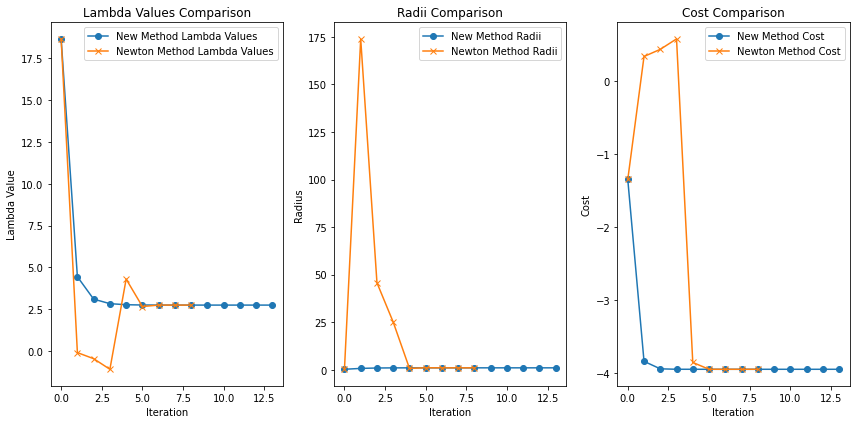

condition number:  5072628045755.374
Newtons method primal violation:  -3.3306690738754696e-16
Newtons Method Iterations: 5
Total time taken for iterations:  0.00042724609375
New method primal violation:  -2.7623924703235048e-08
New method Iterations: 12
Total time taken for iterations:  0.0009255409240722656


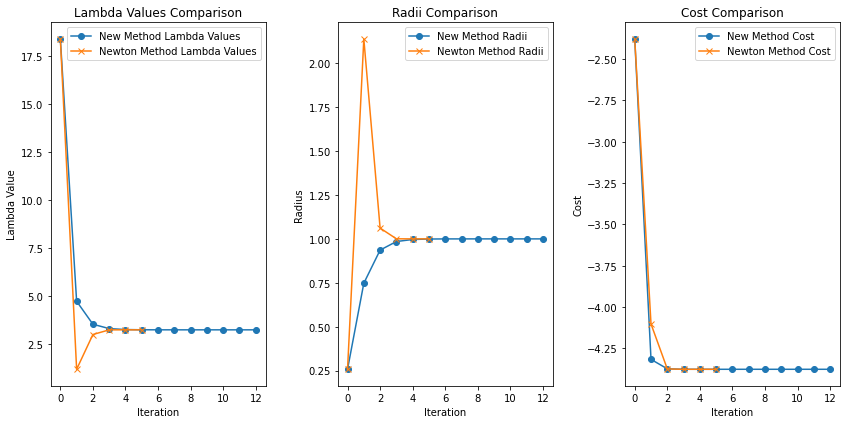

condition number:  2507696550395.066
Iteration limit reached: 20. Stopping the solver.
Newtons method primal violation:  13.743589934965366
Newtons Method Iterations: 20
Total time taken for iterations:  0.002020597457885742
New method primal violation:  -5.4663654380782134e-08
New method Iterations: 12
Total time taken for iterations:  0.0007333755493164062


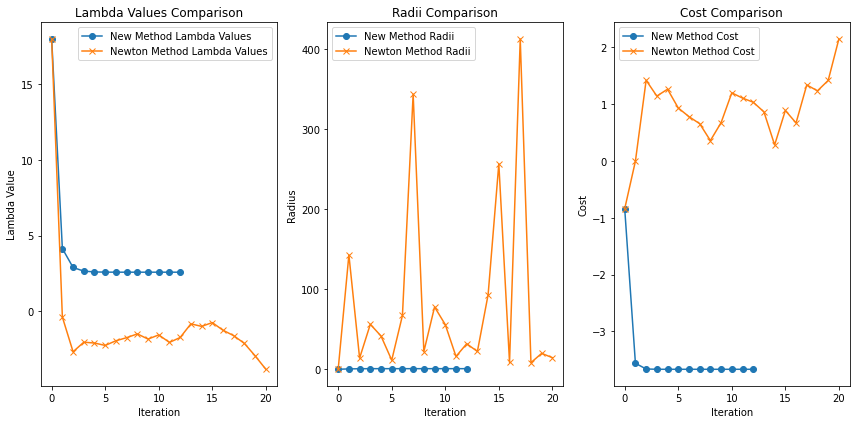

condition number:  2455873708.9155025
Newtons method primal violation:  -1.1102230246251565e-16
Newtons Method Iterations: 6
Total time taken for iterations:  0.0007319450378417969
New method primal violation:  -3.0470086009870556e-08
New method Iterations: 12
Total time taken for iterations:  0.0009326934814453125


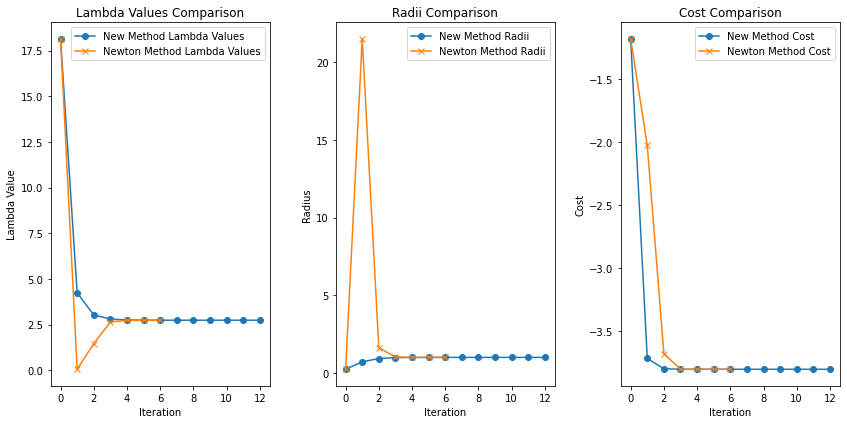

condition number:  34585784091.92016
Newtons method primal violation:  0.0
Newtons Method Iterations: 6
Total time taken for iterations:  0.0006475448608398438
New method primal violation:  -3.9998796608209375e-08
New method Iterations: 12
Total time taken for iterations:  0.0007746219635009766


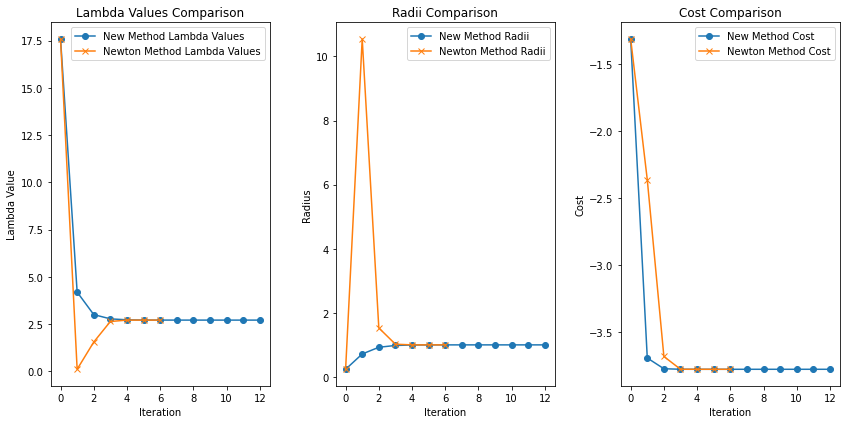

In [18]:
import time


N = 1000 # Example dimension, can be adjusted as needed

delta = 1.0 # radius of the feasible set. This set is a ball centered at the origin.

for _ in range(10):  # Run multiple times to ensure randomness
    np.random.seed(int(time.time()))
    while True:
        Q_sqrt = np.random.rand(N, N)
        Q = Q_sqrt @ Q_sqrt.T  # Ensure Q is positive definite
        g = np.random.rand(N) * 1

        unconstrained_solution = np.linalg.solve(Q, g)
        unconstrained_solution_norm = np.linalg.norm(unconstrained_solution)
        if unconstrained_solution_norm >= delta:
            break
        else:
            np.random.seed(int((time.time() % 1000) * 100))

    cost_struct = QuadraticCostStruct(Q=Q, g=g)

    solver_input = SolverInput(
        cost_struct=cost_struct,
        radius=delta,
        tolerance=1e-6, # convergence criterion. We have defined this as the difference between the solution norm and the desired radius.
        use_eigendecomp=True, 
    )


    print("condition number: ", np.linalg.cond(Q))
    new_exp_data, newton_exp_data = CompareSols(solver_input)
    plot_result_data(new_exp_data, newton_exp_data)

Similar with findings in the previous section, the new method seems to converge to an approximate solution faster, but take longer to come to a more exact solution (this is not a rigorous finding, just an observation). 

This is assuming the original method converges in the first place. In many of the cases shown, the system either did not converge, or converged to a solution with $\lambda < 0$, which may be inaccurate.